In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import lmfit
import ilmfit # interactive plotting of lmfit models

In [2]:
# enable interactive figures in browser
%matplotlib notebook 

In [3]:
sorted(os.listdir('data/A344/raw'))

['A344_GdN_FC_050_Oe_160908.rso.raw',
 'A344_GdN_FC_500_Oe_160908.rso.raw',
 'A344_GdN_MH_005K_160905.rso.raw',
 'A344_GdN_MH_010K_160905.rso.raw',
 'A344_GdN_MH_010K_160908.rso.raw',
 'A344_GdN_MH_020K_160905.rso.raw',
 'A344_GdN_MH_020K_160908.rso.raw',
 'A344_GdN_MH_030K_160908.rso.raw',
 'A344_GdN_MH_040K_160905.rso.raw',
 'A344_GdN_MH_050K_160905.rso.raw',
 'A344_GdN_MH_055K_160905.rso.raw',
 'A344_GdN_MH_060K_160905.rso.raw',
 'A344_GdN_MH_065K_160905.rso.raw',
 'A344_GdN_MH_070K_160905.rso.raw',
 'A344_GdN_MH_075K_160905.rso.raw',
 'A344_GdN_ZFC_050_Oe_160908.rso.raw',
 'A344_GdN_ZFC_500_Oe_160908.rso.raw',
 'A344_cool_zero_field_050_160908.rso.raw',
 'A344_cool_zero_field_500_160908.rso.raw']

In [4]:
fname = 'data/A344/raw/A344_GdN_FC_050_Oe_160908.rso.raw'
raw_data_fc = np.genfromtxt(fname,
                        delimiter = ',', names = True, skip_header = 30)
raw_data_fc.dtype.names

('Time',
 'Comment',
 'Field_Oe',
 'Start_Temperature_K',
 'End_Temperature_K',
 'Scan',
 'Rejected',
 'Position_cm',
 'Long_Voltage',
 'Long_Average_Voltage',
 'Long_Detrended_Voltage',
 'Long_Demeaned_Voltage',
 'Long_Reg_Fit',
 'Long_Detrended_Fit',
 'Long_Demeaned_Fit',
 'Long_Scaled_Response',
 'Long_Avg_Scaled_Response',
 'Long_Background_Response',
 'Long_Response_wABS',
 'Long_Detrended_Resp_wABS',
 'Long_Fit_wABS',
 'Long_Detrended_Fit_wABS',
 'Trans_Voltage',
 'Trans_Average_Voltage',
 'Trans_Detrended_Voltage',
 'Trans_Demeaned_Voltage',
 'Trans_Reg_Fit',
 'Trans_Detrended_Fit',
 'Trans_Demeaned_Fit',
 'Trans_Scaled_Response',
 'Trans_Avg_Scaled_Response',
 'Trans_Background_Response',
 'Trans_Response_wABS',
 'Trans_Detrended_Resp_wABS',
 'Trans_Adjusted_Fit',
 'Trans_Detrended_Fit_wABS',
 'f0')

In [5]:
# filter columns with no data
used_columns = [c for c in raw_data_fc.dtype.names if ~np.all(np.isnan(raw_data_fc[c]))]
raw_data_fc = raw_data_fc[used_columns]

In [6]:
raw_data_fc.dtype.names

('Time',
 'Field_Oe',
 'Start_Temperature_K',
 'End_Temperature_K',
 'Scan',
 'Rejected',
 'Position_cm',
 'Long_Voltage',
 'Long_Average_Voltage',
 'Long_Detrended_Voltage',
 'Long_Demeaned_Voltage',
 'Long_Reg_Fit',
 'Long_Detrended_Fit',
 'Long_Demeaned_Fit',
 'Long_Scaled_Response',
 'Long_Avg_Scaled_Response')

In [7]:
raw_data_fc.shape

(11008,)

In [8]:
# calculate how many lines correspond to each rso scan
n_pts = np.nonzero(np.diff(raw_data_fc['Time']))[0][0] + 1
print(f'Number of points per scan: {n_pts}')

Number of points per scan: 64


In [9]:
# reshape array so that first index corresponds to a whole scan
raw_data_fc = raw_data_fc.reshape(-1, n_pts)

In [10]:
raw_data_fc['Position_cm'][0]

array([2.591049  , 2.365994  , 2.139604  , 1.914313  , 1.692222  ,
       1.475019  , 1.264075  , 1.06069   , 0.8664142 , 0.6833521 ,
       0.5143535 , 0.3630108 , 0.2334378 , 0.1298506 , 0.05602222,
       0.01471969, 0.0072415 , 0.03315883, 0.09032404, 0.1751551 ,
       0.283147  , 0.4095127 , 0.5498305 , 0.7005737 , 0.8594255 ,
       1.02533   , 1.198287  , 1.378954  , 1.568149  , 1.766382  ,
       1.9735    , 2.188529  , 2.409722  , 2.634777  , 2.861167  ,
       3.086458  , 3.308549  , 3.525752  , 3.736696  , 3.940081  ,
       4.134357  , 4.317419  , 4.486418  , 4.63776   , 4.767334  ,
       4.870921  , 4.944749  , 4.986052  , 4.99353   , 4.967612  ,
       4.910447  , 4.825616  , 4.717624  , 4.591259  , 4.450941  ,
       4.300197  , 4.141346  , 3.975441  , 3.802484  , 3.621818  ,
       3.432622  , 3.234389  , 3.027271  , 2.812242  ])

<IPython.core.display.Javascript object>


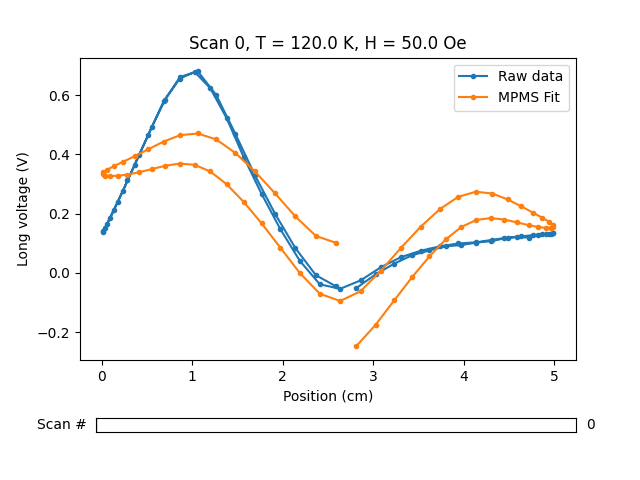

In [11]:
#
position = raw_data_fc['Position_cm']
voltage = raw_data_fc['Long_Voltage']
voltage_fit = raw_data_fc['Long_Reg_Fit']
start_temperature = raw_data_fc['Start_Temperature_K'][:,0]
field = raw_data_fc['Field_Oe'][:,0]

# interactive plot to switch between scans in the raw data
fig1, ax1 = plt.subplots()
ax1.set_xlabel('Position (cm)')
ax1.set_ylabel('Long voltage (V)')

# make space for slider
fig1.subplots_adjust(bottom = 0.25)

# create a slider which can be used to change index of shown scan
slider_ax1 = fig1.add_axes([0.15, 0.1, 0.75, 0.03])
scan_slider1 = Slider(ax = slider_ax1, label = 'Scan #', valmin = 0, valmax = len(raw_data_fc) - 1, valstep = 1)
raw_line1, = ax1.plot(position[0], voltage[0], label = 'Raw data', marker = '.')
fit_line1, = ax1.plot(position[0], voltage_fit[0], label = 'MPMS Fit', marker = '.')
ax1.set_title(f'Scan {0}, T = {start_temperature[0]:.1f} K, H = {field[0]:.1f} Oe')
def update_1(n):
    # update the data of each line to show the i
    n = int(n)
    raw_line1.set_data(position[n], voltage[n])
    fit_line1.set_data(position[n], voltage_fit[n])
    raw_line1.axes.set_title(f'Scan {n}, T = {start_temperature[n]:.1f} K, H = {field[n]:.1f} Oe')
    raw_line1.axes.relim()
    raw_line1.axes.autoscale_view()
scan_slider1.on_changed(update_1)
ax1.legend()

<IPython.core.display.Javascript object>


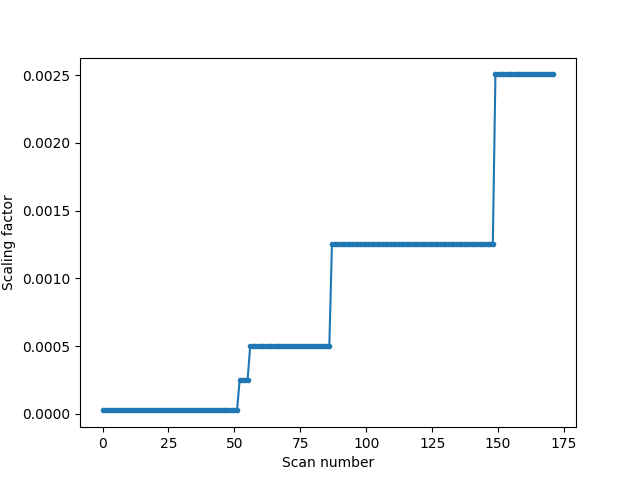

Text(0, 0.5, 'Scaling factor')

In [12]:
# Get the scaling factor used by the MPMS
# Ignore possible divisions by zero
with np.errstate(divide = 'ignore', invalid = 'ignore'):
    scale_factor = raw_data_fc['Long_Scaled_Response']/raw_data_fc['Long_Voltage']
    scale_factor = np.nanmean(scale_factor, axis = 1).reshape(-1, 1)
fig2, ax2 = plt.subplots()
ax2.plot(scale_factor, marker = '.')
ax2.set_xlabel('Scan number')
ax2.set_ylabel('Scaling factor')

<IPython.core.display.Javascript object>


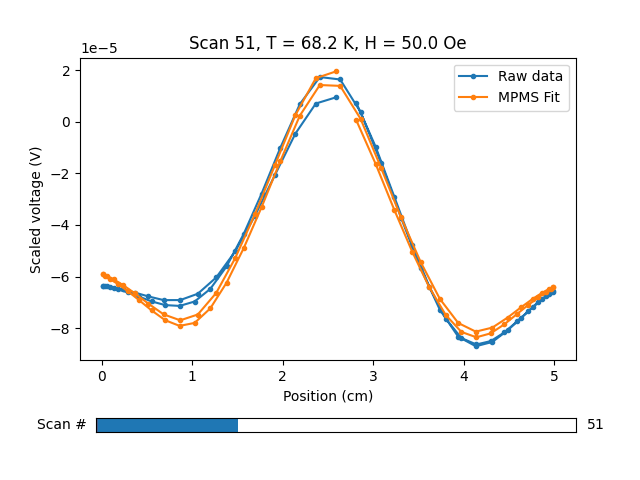

In [13]:
#
position = raw_data_fc['Position_cm']
scaled_voltage = raw_data_fc['Long_Scaled_Response']
voltage_fit = raw_data_fc['Long_Reg_Fit']
scaled_fit = voltage_fit * scale_factor
start_temperature = raw_data_fc['Start_Temperature_K'][:,0]
field = raw_data_fc['Field_Oe'][:,0]

# interactive plot to switch between scans in the raw data
fig3, ax3 = plt.subplots()
ax3.set_xlabel('Position (cm)')
ax3.set_ylabel('Scaled voltage (V)')

# make space for slider
fig3.subplots_adjust(bottom = 0.25)

# create a slider which can be used to change index of shown scan
slider_ax2 = fig3.add_axes([0.15, 0.1, 0.75, 0.03])
scan_slider2 = Slider(ax = slider_ax2, label = 'Scan #', valmin = 0, valmax = len(raw_data_fc) - 1, valstep = 1)
raw_line2, = ax3.plot(position[0], scaled_voltage[0], label = 'Raw data', marker = '.')
fit_line2, = ax3.plot(position[0], scaled_fit[0], label = 'MPMS Fit', marker = '.')
ax3.set_title(f'Scan {0}, T = {start_temperature[0]:.1f} K, H = {field[0]:.1f} Oe')
def update_2(n):
    # update the data of each line to show the i
    n = int(n)
    raw_line2.set_data(position[n], scaled_voltage[n])
    fit_line2.set_data(position[n], scaled_fit[n])
    raw_line2.axes.set_title(f'Scan {n}, T = {start_temperature[n]:.1f} K, H = {field[n]:.1f} Oe')
    raw_line2.axes.relim()
    raw_line2.axes.autoscale_view()
scan_slider2.on_changed(update_2)
ax3.legend()

In [14]:
# Equation from https://www.qdusa.com/siteDocs/appNotes/1014-213.pdf
# modified so x4 is positive center offset
def rso_response(pos, x1 = 0, x2 = 0, x3 = 1e-4, x4 = 2.5):
    R = 0.97
    L = 1.519
    v_i = np.linspace(0, 1, len(pos))                                          
    X = R**2 + (pos - x4)**2                                                    
    Y = R**2 + (L + (pos - x4))**2                                              
    Z = R**2 + (-L + (pos - x4))**2                                            
    return x1 + x2*v_i + x3*(2*X**(-3/2) - Y**(-3/2) - Z**(-3/2))

In [15]:
# making lmfit model from rso_response which can be used to fit data
rso_model = lmfit.Model(rso_response)

<IPython.core.display.Javascript object>


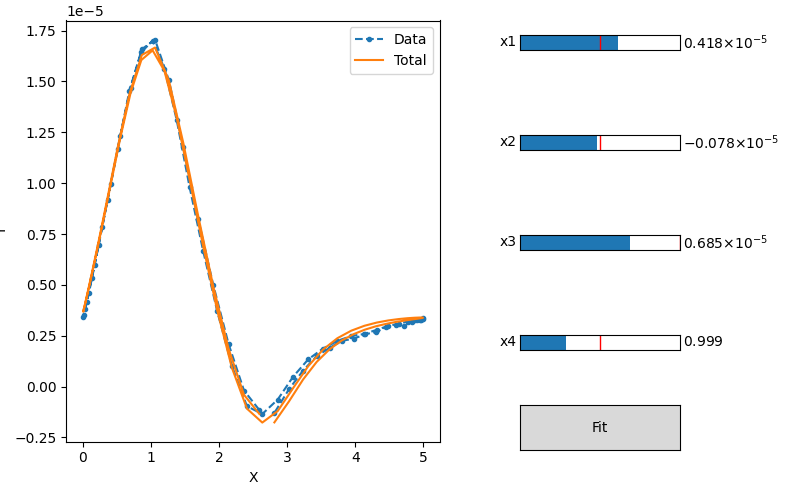

In [16]:
# peak to peak magnitude used to define bounds for x1, x2, x3
vp = raw_data_fc['Long_Scaled_Response'][0].ptp()
scan_fitter = ilmfit.Ilmfit(rso_model,
                   x = raw_data_fc['Position_cm'][0],
                   y = raw_data_fc['Long_Scaled_Response'][0],
                   bounds = {'x1': (-vp, vp), 'x2': (-vp, vp), 'x3': (-vp, vp), 'x4': (-1, 6)})

In [17]:
# fit scan with specified initial parameters
scan_fitter.fit(x1 = 0, x2 = 0, x3 = 1e-5, x4 = 1)
scan_fitter.res.params

name,value,standard error,relative error,initial value,min,max,vary
x1,4.1839e-06,7.8258e-08,(1.87%),0,-inf,inf,True
x2,-7.7874e-07,1.2870e-07,(16.53%),0,-inf,inf,True
x3,6.8486e-06,5.1390e-08,(0.75%),1e-05,-inf,inf,True
x4,0.99873070,0.00349008,(0.35%),1,-inf,inf,True


<IPython.core.display.Javascript object>


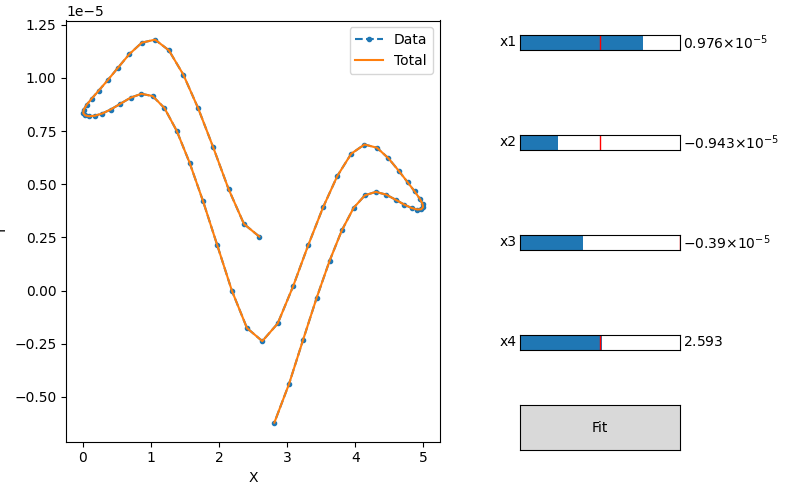

In [18]:
# Check what parameters the MPMS fit resulted in
vp = scaled_fit[0].ptp()
mpms_fitter = ilmfit.Ilmfit(rso_model,
                   x = position[0],
                   y = scaled_fit[0],
                   bounds = {'x1': (-vp, vp), 'x2': (-vp, vp), 'x3': (-vp, vp), 'x4': (-1, 6)})

In [19]:
mpms_fitter.fit(x1 = 0, x2 = 0, x3 = 0, x4 = 2.5)
mpms_fitter.res.params

name,value,standard error,relative error,initial value,min,max,vary
x1,9.7576e-06,3.1971e-13,(0.00%),0,-inf,inf,True
x2,-9.4338e-06,5.6156e-13,(0.00%),0,-inf,inf,True
x3,-3.9031e-06,1.9825e-13,(0.00%),0,-inf,inf,True
x4,2.59325362,3.1967e-08,(0.00%),2.5,-inf,inf,True


In [20]:
# calculate x3-emu conversion factor using the mpms fit parameters and
# originally saved .dat file
fc_data = np.genfromtxt('data/A344/dat/A344_GdN_FC_050_Oe_160908.rso.dat',
                        delimiter = ',', names = True, skip_header = 30)
emu_conversion_factor = fc_data['Long_Moment_emu'][0]/mpms_fitter.res.params['x3'].value
print(f'x3 to emu conversion factor: {emu_conversion_factor}')

x3 to emu conversion factor: 1.0958903558556818


<IPython.core.display.Javascript object>


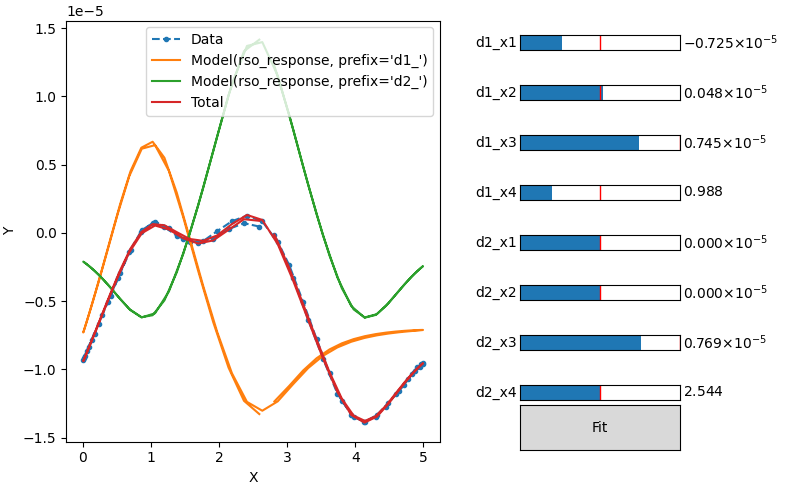

In [21]:
# Example of scan with two clear dipole contributions with similar magnitudes
x, y = position[47], scaled_voltage[47]
vp = y.ptp()
# can create composite models by adding together; need to have unique prefixes
rso_model_n = lmfit.Model(rso_response, prefix = 'd1_') + lmfit.Model(rso_response, prefix = 'd2_')
rso_model_n.set_param_hint('d2_x1', vary = False)
rso_model_n.set_param_hint('d2_x2', vary = False)
rso_model_n.set_param_hint('d1_x4', min = 0, max = 5)
rso_model_n.set_param_hint('d2_x4', min = 0, max = 5)
rso_model_n.set_param_hint('d1_moment', expr = '1.09589*d1_x3')
rso_model_n.set_param_hint('d2_moment', expr = '1.09589*d2_x3')
bounds = {k:(-vp, vp) for k in ['d1_x1', 'd1_x2', 'd1_x3', 'd2_x1', 'd2_x2', 'd2_x3']}
scan_fitter_2 = ilmfit.Ilmfit(rso_model_n, x = x, y = y, bounds = bounds)

In [22]:
scan_fitter_2.fit(d1_x4 = 1, d2_x4 = 2.5)
scan_fitter_2.res.params

name,value,standard error,relative error,initial value,min,max,vary,expression
d1_x1,-7.2528e-06,5.9424e-08,(0.82%),0,-inf,inf,True,
d1_x2,4.7792e-07,9.6622e-08,(20.22%),0,-inf,inf,True,
d1_x3,7.4499e-06,4.2634e-08,(0.57%),1.5128672e-05,-inf,inf,True,
d1_x4,0.98791603,0.00316823,(0.32%),1,0.00000000,5.00000000,True,
d2_x1,0.00000000,0.00000000,,0,-inf,inf,False,
d2_x2,0.00000000,0.00000000,,0,-inf,inf,False,
d2_x3,7.6886e-06,4.0113e-08,(0.52%),1.5128672e-05,-inf,inf,True,
d2_x4,2.54389491,0.00313664,(0.12%),2.5,0.00000000,5.00000000,True,
d1_moment,8.1642e-06,4.6722e-08,(0.57%),1.657936035808e-05,-inf,inf,False,1.09589*d1_x3
d2_moment,8.4258e-06,4.3960e-08,(0.52%),1.657936035808e-05,-inf,inf,False,1.09589*d2_x3


In [23]:
scan_fitter.res.params

name,value,standard error,relative error,initial value,min,max,vary
x1,4.1839e-06,7.8258e-08,(1.87%),0,-inf,inf,True
x2,-7.7874e-07,1.2870e-07,(16.53%),0,-inf,inf,True
x3,6.8486e-06,5.1390e-08,(0.75%),1e-05,-inf,inf,True
x4,0.99873070,0.00349008,(0.35%),1,-inf,inf,True


In [24]:
# fitting two dipole moments to each scan
fits = []
last_params = scan_fitter_2.res.params
last_params['d1_x4'].set(min = 0.97, max = 1.01)
last_params['d2_x4'].set(min = 2.49, max = 2.56)
for i in range(len(raw_data_fc)):
    res = rso_model_n.fit(scaled_voltage[i], pos = position[i], params = last_params)
    fits.append(res)
    last_params = res.params

<IPython.core.display.Javascript object>


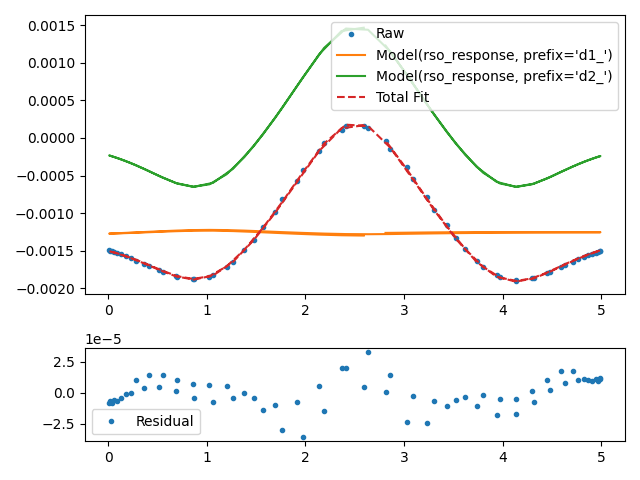

In [25]:
ilmfit.plot_res(fits[100])

In [26]:
# subtracting high temperature offset dipole from each scan data
fits2 = []
model = lmfit.Model(rso_response, prefix = 'd1_')
model.set_param_hint('moment', expr = '1.09589*d1_x3')
last_params = model.make_params()
last_params['d1_x4'].set(min = 2.52, max = 2.56)
scan_fitter.fit(x1 = 1)
for i in range(len(raw_data_fc)):
    pos = position[i]
    voltage_c = scaled_voltage[i] - scan_fitter.res.eval(pos = pos)
    res = model.fit(voltage_c, pos = pos, params = last_params)
    fits2.append(res)
    last_params = res.params

<IPython.core.display.Javascript object>


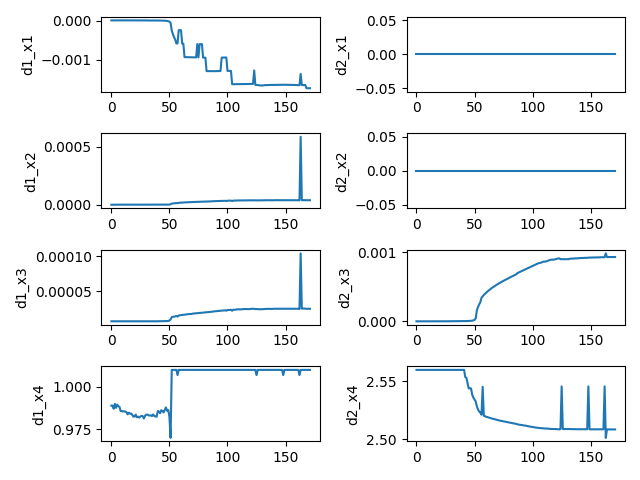

In [27]:
# overview of fitting parameters for each scan
fig4, axes = plt.subplots(4, 2)
for axi, p in zip(axes.T.flatten(), fits[0].params.keys()):
    axi.set_ylabel(p)
    axi.plot([f.params[p].value for f in fits])
fig4.tight_layout()

<IPython.core.display.Javascript object>


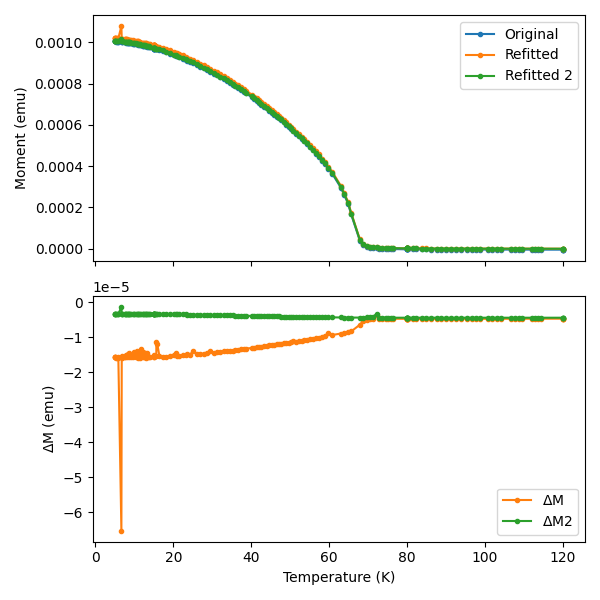

In [28]:
fig5, (ax5, ax5b) = plt.subplots(2, 1, sharex = True)
fig5.set_size_inches(6, 6)
temperature = fc_data['Temperature_K']
moment_orig = fc_data['Long_Moment_emu']
moment_refit = np.array([f.params['d2_moment'] for f in fits])
moment_refit2 = np.array([f.params['d1_moment'] for f in fits2])
ax5.plot(temperature, moment_orig, marker = '.', label = 'Original')
ax5.plot(temperature, moment_refit, marker = '.', label = 'Refitted')
ax5.plot(temperature, moment_refit2, marker = '.', label = 'Refitted 2')
ax5b.plot(temperature, moment_orig - moment_refit, color = 'C1', marker = '.', label = r'$\Delta$M')
ax5b.plot(temperature, moment_orig - moment_refit2, color = 'C2', marker = '.', label = r'$\Delta$M2')
ax5b.set_xlabel('Temperature (K)')
ax5.set_ylabel('Moment (emu)')
ax5b.set_ylabel(r'$\Delta$M (emu)')
ax5.legend()
ax5b.legend()
fig5.tight_layout()

<IPython.core.display.Javascript object>


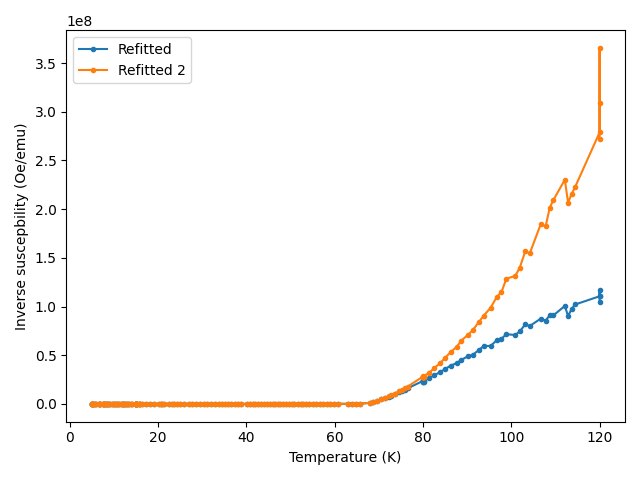

In [29]:
# check linearity of inverse susceptibility
fig6, ax6 = plt.subplots(1, 1)
temperature = fc_data['Temperature_K']
applied_field = fc_data['Field_Oe'][0]
moment_refit = np.array([f.params['d2_moment'] for f in fits])
moment_refit2 = np.array([f.params['d1_moment'] for f in fits2])
ax6.plot(temperature, applied_field/moment_refit, marker = '.', label = 'Refitted')
ax6.plot(temperature, applied_field/moment_refit2, marker = '.', label = 'Refitted 2')
ax6.set_xlabel('Temperature (K)')
ax6.set_ylabel('Inverse suscepbility (Oe/emu)')
ax6.legend()
fig6.tight_layout()

In [30]:
# curie weiss with correction for constant moment offset
k_B = 1.380649e-16 # erg/K
mu_b = 9.274009994e-21 # erg/G, emu
# gd ion
g = 2
J = 7/2
mu_eff = mu_b * g * np.sqrt(J*(J + 1))

idx = temperature>90
inv_susc = applied_field/(moment_refit + moment_refit2)*2
m, c = np.polyfit(temperature[idx], inv_susc[idx], 1)
print(f'T_C = {-c/m:.2f} K')
print(f'N_Gd = {3*k_B/(mu_eff**2 * m)}')

T_C = 73.28 K
N_Gd = 2.2169110022428816e+16
